In [1]:
# print date
import datetime
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2024-11-01 14:32:06


In [35]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar
from scipy import stats

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

FIGDIR = '/Users/harishbaki/Dropbox/Apps/Overleaf/NAWEA_full_paper_submitted_to_WES_special_collection'

In [43]:
def hexbin_plotter(fig,gs,Y,pred,title,text_arg=None,text_loc=None,errors_to_show=[r'$R^2$', 'RMSE', 'MAE'],xlabel=None,ylabel=None, 
                   xlims=None, ylims = None,colorbar=None):
    '''
    Plots hebxin between true and predictions of Y
    fig: figure handle
    gs: grid spect handle
    Y: target (train or test or true) 
    pred: prediction from a model
    title: title of the figure
    text_arg: whether to add text with in the plot or not
    xlabel_arg: some cases, the xlabel is not needed, this specifies that
    ylabel_arg: some cases, the ylabel is not needed, this specifies that 
    '''
    # Calculate error metrics
    err_metrics = {
        'MAE': mae(Y, pred),
        'RMSE': np.sqrt(mse(Y, pred)),
        'MAPE': mape(Y, pred),
        r'$R^2$': R2(Y, pred)
    }

    ax_hexbin = fig.add_subplot(gs)
    hb = ax_hexbin.hexbin(np.squeeze(Y), np.squeeze(pred), gridsize=100, bins='log', cmap='inferno')
    if text_arg:
        error_text = '\n'.join([f'{error}: {err_metrics[error]:.2f}' for error in errors_to_show if error in err_metrics])
        ax_hexbin.text(text_loc[0],text_loc[1], error_text, transform=ax_hexbin.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    if xlabel:
        ax_hexbin.set_xlabel(xlabel)
    if ylabel:
        ax_hexbin.set_ylabel(ylabel)
    ax_hexbin.set_title(f'{title}')

    if xlims and ylims:
        ax_hexbin.set_xlim(xlims[0], xlims[1])
        ax_hexbin.set_ylim(ylims[0], ylims[1])
        ax_hexbin.plot([xlims[0], xlims[1]], [ylims[0], ylims[1]], 'k--')
    else:
        min_value = Y.min()
        max_value = Y.max()
        ax_hexbin.set_xlim(min_value, max_value)
        ax_hexbin.set_ylim(min_value, max_value)
        ax_hexbin.plot([min_value, max_value], [min_value, max_value], 'k--')
    return hb

In [64]:
# === Input parameters ===
target_variables = [0,1,2,3,4]

test_station_ids = ['PROF_CLYM','PROF_OWEG','PROF_STAT','PROF_STON','PROF_QUEE','PROF_SUFF','PROF_BUFF','PROF_BELL','PROF_TUPP',
                    'PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

profiler_coeff_all, NOW23_coeff_all = {},{}
profiler_profiles_all, NOW23_profiles_all = {},{}
for station_id in test_station_ids:
    profiler_ds  = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients/Averaged_over_55th_to_5th_min/{station_id}.nc')
    profiler_data = profiler_ds.Chebyshev_Coefficients.sel(time=slice('2018-01-01T00',f'2020-12-31T23'))
    # Extracting non_missing and excluding outliers
    profiler_data = profiler_data.where(profiler_data.non_missing_outlier==1, drop=True)

    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc')
    NOW23_data = NOW23_ds.Chebyshev_Coefficients.sel(time=slice('2018-01-01T00',f'2020-12-31T23'))
    NOW23_data = NOW23_data.sel(time=profiler_data.time.values)
    profiler_coeff_all[station_id] = profiler_data
    NOW23_coeff_all[station_id] = NOW23_data

    # true profiler and NOW23 data
    profiler_profiles_ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/Averaged_over_55th_to_5th_min/{station_id}.nc').wind_speed
    NOW23_profiles_ds = xr.open_dataset(f'data/NOW23_profiles/{station_id}.nc').wind_speed

    profiler_profiles = profiler_profiles_ds.sel(range=slice(10,500),time=profiler_data.time.values).T
    NOW23_profiles = NOW23_profiles_ds.sel(time=profiler_data.time.values)
    profiler_profiles_all[station_id] = profiler_profiles
    NOW23_profiles_all[station_id] = NOW23_profiles

    print(f'{station_id} processed', profiler_data.time.size, NOW23_data.time.size, profiler_profiles.time.size, NOW23_profiles.time.size)

PROF_CLYM processed 10583 10583 10583 10583
PROF_OWEG processed 15028 15028 15028 15028
PROF_STAT processed 13269 13269 13269 13269
PROF_STON processed 10990 10990 10990 10990
PROF_QUEE processed 14365 14365 14365 14365
PROF_SUFF processed 4896 4896 4896 4896
PROF_BUFF processed 9760 9760 9760 9760
PROF_BELL processed 7492 7492 7492 7492
PROF_TUPP processed 9631 9631 9631 9631
PROF_WANT processed 16705 16705 16705 16705
PROF_BRON processed 15667 15667 15667 15667
PROF_REDH processed 13045 13045 13045 13045
PROF_JORD processed 14185 14185 14185 14185


# Wind speed profiles comparison

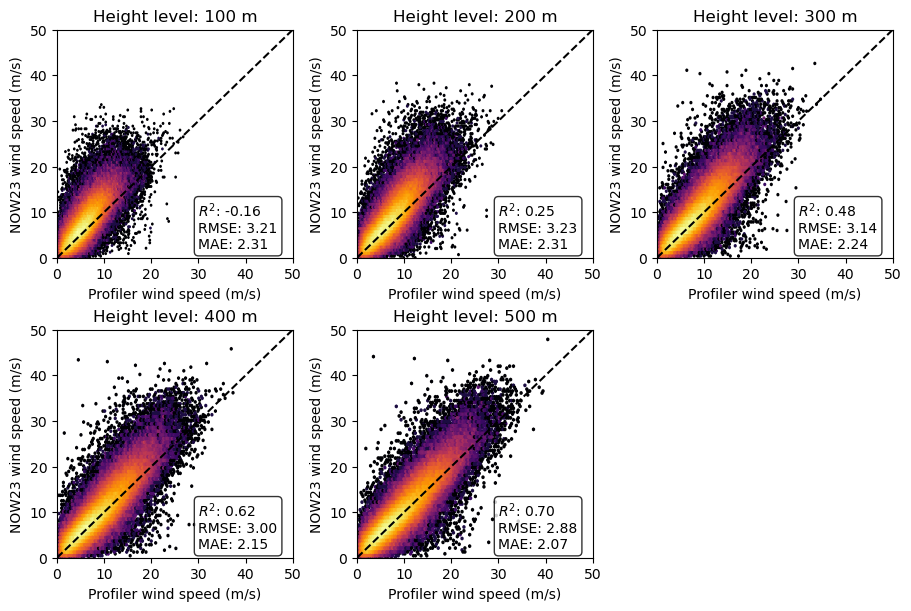

In [72]:
# combine the coefficient data
profiler_profiles_combined = xr.concat([profiler_profiles_all[station_id] for station_id in test_station_ids], dim='time')
NOW23_profiles_combined = xr.concat([NOW23_profiles_all[station_id] for station_id in test_station_ids], dim='time')

XLIMS = [[0,40],[-5,25],[-12.5,5],[-5,5],[-6,5]]
YLIMS = [[0,40],[-5,25],[-12.5,5],[-5,5],[-6,5]]
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for i,level in enumerate([100,200,300,400,500]):
    row, col = divmod(i, 3)
    ylabel = f'NOW23 wind speed (m/s)' 
    xlabel = 'Profiler wind speed (m/s)'
    xlims = [0,50]
    ylims = [0,50]
    text_loc = [0.6, 0.25]
    hexbin_plotter(fig,gs[row,col],profiler_profiles_combined.sel(range=level),
                NOW23_profiles_combined.sel(levels=level),
                f'Height level: {level} m',text_arg=True, text_loc = text_loc,
                xlabel=xlabel, ylabel=ylabel,
                xlims=xlims, ylims=ylims)
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_wind_speed_Hexbins_all_locations_combined.pdf',bbox_inches='tight',dpi=300)

# Wind speed Q-Q plot

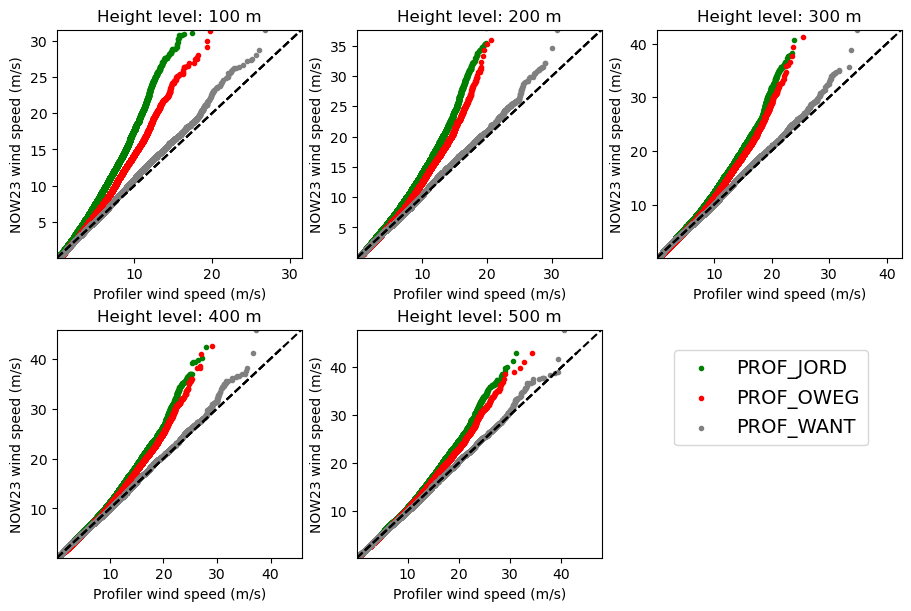

In [ ]:
# Onshore
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for i,level in enumerate([100,200,300,400,500]):
    row, col = divmod(i, 3)
    ylabel = f'NOW23 wind speed (m/s)'
    xlabel = 'Profiler wind speed (m/s)'
    title = f'Height level: {level} m'
    ax = fig.add_subplot(gs[row,col])
    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        profiler_profiles = profiler_profiles_all[station_id]
        NOW23_profiles = NOW23_profiles_all[station_id]
        color = colors[i]
        ax.scatter(np.sort(np.nan_to_num(profiler_profiles.sel(range=level).values)),
            np.sort(NOW23_profiles.sel(levels=level).values),marker='.',color=color,label=station_id)
        min_value = NOW23_profiles.sel(levels=level).min().values
        max_value = NOW23_profiles.sel(levels=level).max().values
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.plot([min_value, max_value], [min_value, max_value], 'k--')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.85, 0.25),fontsize=14)
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_profiles_Q-Q_onshore_offshore_locations.pdf',bbox_inches='tight',dpi=300)

# wind speed weibull distribution comparison

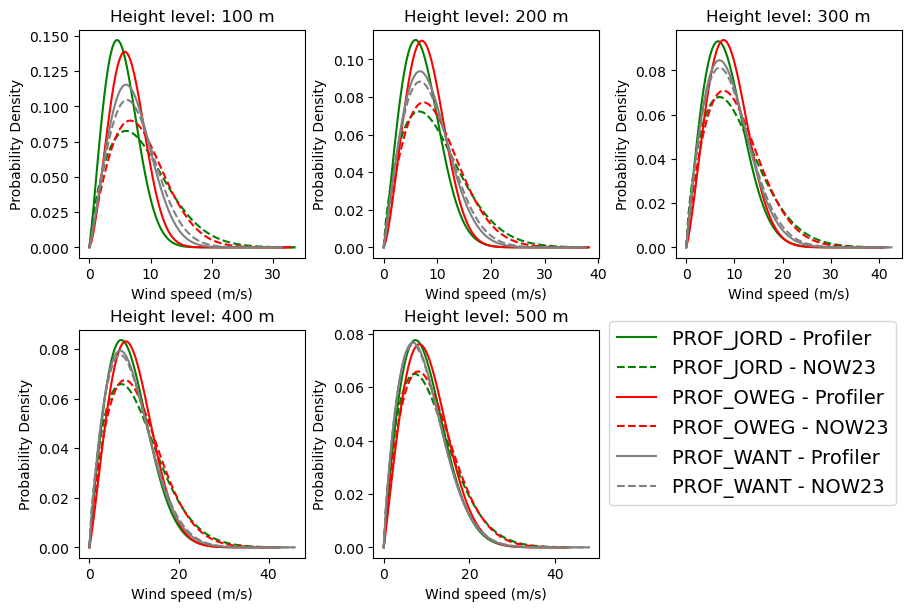

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Define your figure layout and grid
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

# Loop through height levels for plotting
for i, level in enumerate([100, 200, 300, 400, 500]):
    row, col = divmod(i, 3)
    title = f'Height level: {level} m'
    ax = fig.add_subplot(gs[row, col])
    colors = ['green', 'red', 'grey']
    
    # Loop through each station and compute Weibull coefficients
    for j, station_id in enumerate(['PROF_JORD', 'PROF_OWEG', 'PROF_WANT']):
        profiler_profiles = profiler_profiles_all[station_id]
        NOW23_profiles = NOW23_profiles_all[station_id]
        color = colors[j]

        # Extract values for the selected level and remove NaNs
        prof_values = profiler_profiles.sel(range=level).values
        now_values = NOW23_profiles.sel(levels=level).values
        prof_values = prof_values[~np.isnan(prof_values)]
        now_values = now_values[~np.isnan(now_values)]

        # Fit Weibull distribution to profiler wind speed data
        shape_prof, loc_prof, scale_prof = weibull_min.fit(prof_values, floc=0)
        shape_now, loc_now, scale_now = weibull_min.fit(now_values, floc=0)
        
        # Generate x values for plotting the Weibull PDFs
        x = np.linspace(0, max(prof_values.max(), now_values.max()), 100)
        
        # Plot the Weibull PDFs for profiler and NOW23 data
        ax.plot(x, weibull_min.pdf(x, shape_prof, loc_prof, scale_prof), color=color, linestyle='-', 
                label=f'{station_id} - Profiler', linewidth=1.5)
        ax.plot(x, weibull_min.pdf(x, shape_now, loc_now, scale_now), color=color, linestyle='--', 
                label=f'{station_id} - NOW23', linewidth=1.5)

        # Display Weibull parameters in a text box
        textstr = (f"Profiler: shape={shape_prof:.2f}, scale={scale_prof:.2f}\n"
                   f"NOW23: shape={shape_now:.2f}, scale={scale_now:.2f}")
        #ax.text(0.05, 0.95 - j*0.15, textstr, transform=ax.transAxes, fontsize=10,
        #        verticalalignment='top', color=color, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Set labels and title for each subplot
    ax.set_xlabel('Wind speed (m/s)')
    ax.set_ylabel('Probability Density')
    ax.set_title(title)

handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.83, 0.15),fontsize=14)

# Save the figure with all Weibull distributions
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Weibull_Distribution_onshore_offshore_locations.pdf', 
            bbox_inches='tight', dpi=300)


# Coefficient Hexbin comparison

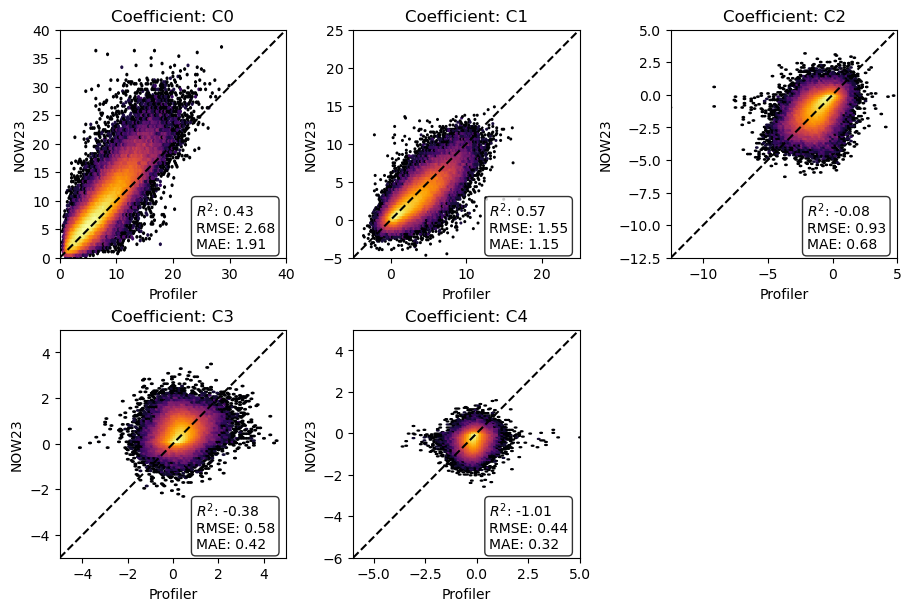

In [49]:
# combine the coefficient data
profiler_coeff_combined = xr.concat([profiler_coeff_all[station_id] for station_id in test_station_ids], dim='time')
NOW23_coeff_combined = xr.concat([NOW23_coeff_all[station_id] for station_id in test_station_ids], dim='time')

XLIMS = [[0,40],[-5,25],[-12.5,5],[-5,5],[-6,5]]
YLIMS = [[0,40],[-5,25],[-12.5,5],[-5,5],[-6,5]]
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for coeff in range(5):
    row, col = divmod(coeff, 3)
    ylabel = f'NOW23' 
    xlabel = 'Profiler'
    xlims = XLIMS[coeff]
    ylims = YLIMS[coeff]
    text_loc = [0.6, 0.25]
    hexbin_plotter(fig,gs[row,col],profiler_coeff_combined.sel(coeff=coeff),
                NOW23_coeff_combined.sel(coeff=coeff),
                f'Coefficient: C{coeff}',text_arg=True, text_loc = text_loc,
                xlabel=xlabel, ylabel=ylabel,
                xlims=xlims, ylims=ylims)
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Chebyshev_coeff_Hexbins_all_locations_combined.pdf',bbox_inches='tight',dpi=300)

## Q-Q plots of coefficients

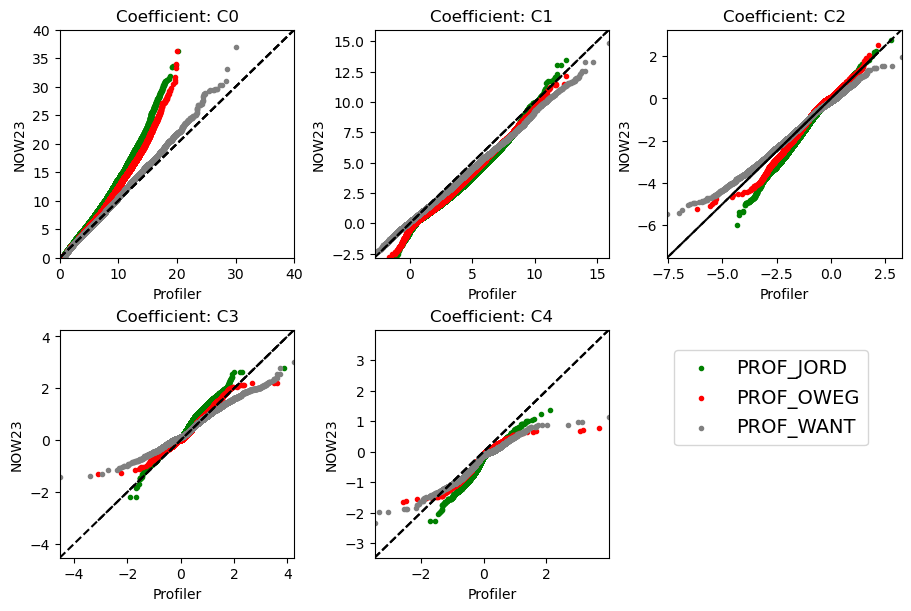

In [58]:
# Onshore
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for coeff in range(5):
    row, col = divmod(coeff, 3)
    ylabel = f'NOW23'
    xlabel = 'Profiler'
    title = f'Coefficient: C{coeff}'
    ax = fig.add_subplot(gs[row,col])
    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]
        color = colors[i]
        ax.scatter(np.sort(profiler_coeff.sel(coeff=coeff)),
                    np.sort(NOW23_coeff.sel(coeff=coeff)),marker='.',color=color,label=station_id)
        if coeff == 0:
            min_value = 0
            max_value = 40
        else:
            min_value = profiler_coeff.sel(coeff=coeff).min().values
            max_value = profiler_coeff.sel(coeff=coeff).max().values
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.plot([min_value, max_value], [min_value, max_value], 'k--')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.85, 0.25),fontsize=14)
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Chebyshev_coeff_Q-Q_onshore_offshore_locations.pdf',bbox_inches='tight',dpi=300)

# Hexbins of Coeff-Coeff plots

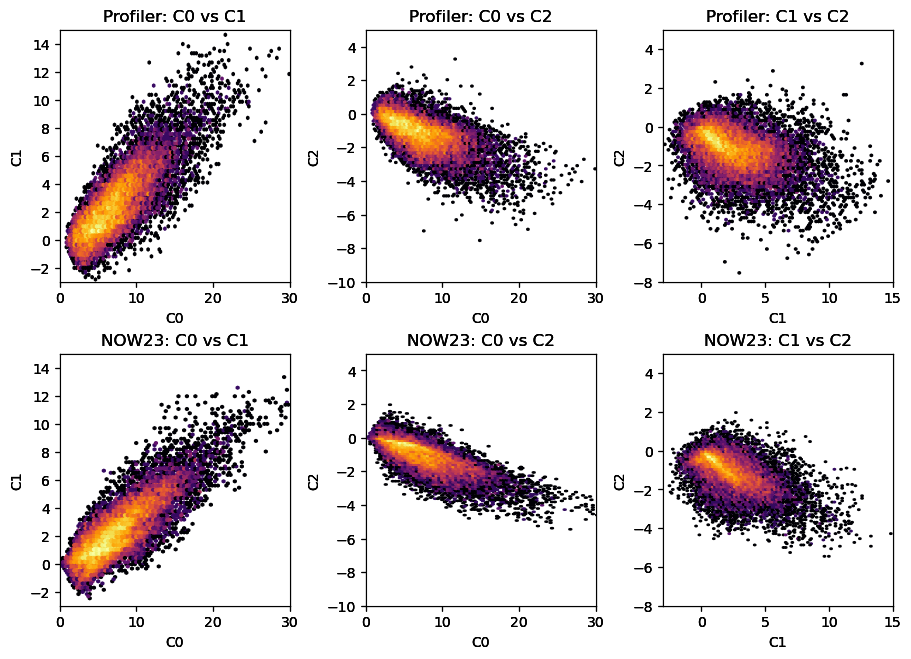

In [62]:
colors = plt.cm.tab20.colors
fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gs = fig.add_gridspec(3, 3)

combinations = [(0, 1), (0, 2), (1, 2)]
x_min,x_max = [0,0,-3], [30, 30, 15]
y_min,y_max = [-3, -10,-8], [15, 5, 5]

for station_id in ['PROF_JORD','PROF_OWEG','PROF_WANT']:
    for row, dataset_name in enumerate(['Profiler','NOW23']):
        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]
        datasets = [profiler_coeff, NOW23_coeff]
        for col, (coeff_x, coeff_y) in enumerate(combinations):
            ax = fig.add_subplot(gs[row, col])
            
            # Generate hexbin plot using extracted x, y data
            fig_title = f'{dataset_name}: C{coeff_x} vs C{coeff_y}'
            x_data, y_data = datasets[row].sel(coeff=coeff_x), datasets[row].sel(coeff=coeff_y)
            ax.hexbin(np.squeeze(x_data), np.squeeze(y_data), gridsize=100, bins='log', cmap='inferno')

            ax.set_xlim(x_min[col], x_max[col])
            ax.set_ylim(y_min[col], y_max[col])
            ax.set_title(fig_title)
            ax.set_xlabel(f'C{coeff_x}')
            ax.set_ylabel(f'C{coeff_y}')
    plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Hexbins_of_coeff-coeff_{station_id}.pdf',bbox_inches='tight',dpi=300)

# Plotting diurnal cycle

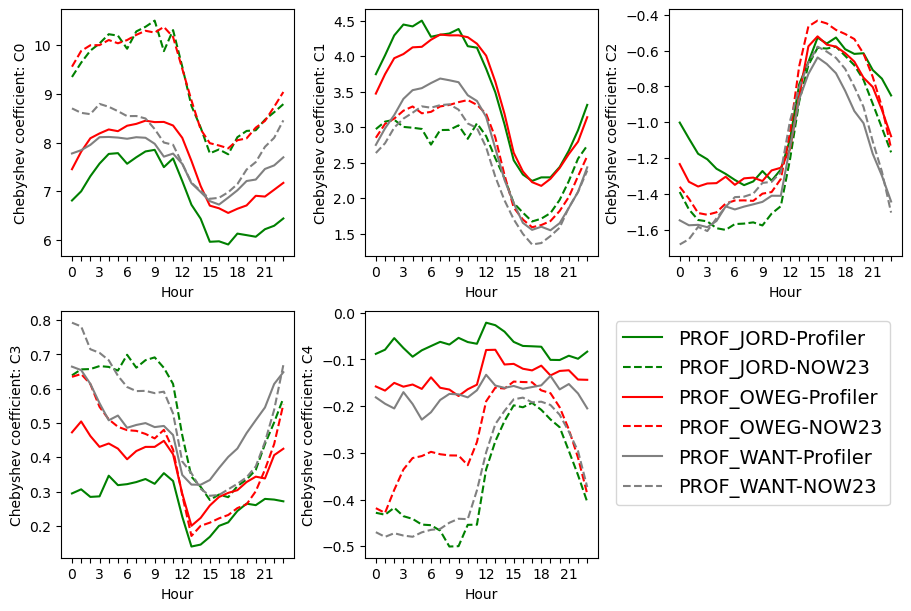

In [97]:
# Onshore
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for coeff in range(5):
    row, col = divmod(coeff, 3)
    ylabel = f'NOW23'
    xlabel = 'Profiler'
    title = f'Coefficient: C{coeff}'
    ax = fig.add_subplot(gs[row,col])
    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]

        profiler_diurnal_avg = profiler_coeff.groupby("time.hour").mean(dim="time")
        NOW23_diurnal_avg = NOW23_coeff.groupby("time.hour").mean(dim="time")

        color = colors[i]
        ax.plot(profiler_diurnal_avg.hour, profiler_diurnal_avg.sel(coeff=coeff),
                linestyle='-',color=color,label=f'{station_id}-Profiler')
        ax.plot(NOW23_diurnal_avg.hour, NOW23_diurnal_avg.sel(coeff=coeff),
                linestyle='--',color=color,label=f'{station_id}-NOW23')

    # Set labels and title for each subplot
    ax.set_xlabel('Hour')
    ax.set_ylabel(f'Chebyshev coefficient: C{coeff}')
    ax.set_xticks(range(24))  # Ticks at every hour
    ax.set_xticklabels([str(h) if h % 3 == 0 else '' for h in range(24)])  # Labels every 3 hours

handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.83, 0.15),fontsize=14)

# Save the figure with all Weibull distributions
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Chebysev_diurbal_cycle_onshore_offshore_locations.pdf', 
            bbox_inches='tight', dpi=300)

# Plotting annual cycle

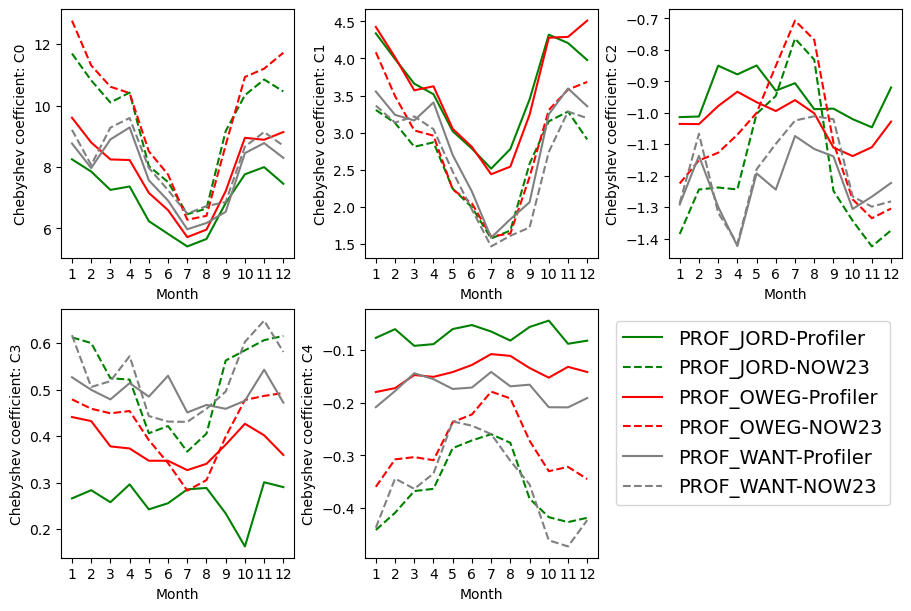

In [98]:
# Onshore
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
gs = fig.add_gridspec(2,3)
for coeff in range(5):
    row, col = divmod(coeff, 3)
    ylabel = f'NOW23'
    xlabel = 'Profiler'
    title = f'Coefficient: C{coeff}'
    ax = fig.add_subplot(gs[row,col])
    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]

        profiler_annual_avg = profiler_coeff.groupby("time.month").mean(dim="time")
        NOW23_annual_avg = NOW23_coeff.groupby("time.month").mean(dim="time")

        color = colors[i]
        ax.plot(profiler_annual_avg.month, profiler_annual_avg.sel(coeff=coeff),
                linestyle='-',color=color,label=f'{station_id}-Profiler')
        ax.plot(NOW23_annual_avg.month, NOW23_annual_avg.sel(coeff=coeff),
                linestyle='--',color=color,label=f'{station_id}-NOW23')

    # Set labels and title for each subplot
    ax.set_xlabel('Month')
    ax.set_ylabel(f'Chebyshev coefficient: C{coeff}')
    ax.set_xticks(range(1,13))  # Ticks at every month

handles, labels = ax.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.83, 0.15),fontsize=14)

# Save the figure with all Weibull distributions
plt.savefig(f'{FIGDIR}/Profiler_vs_NOW23_Chebysev_annual_cycle_onshore_offshore_locations.pdf', 
            bbox_inches='tight', dpi=300)

In [101]:
months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
monthly_df = pd.DataFrame()
for j,month in enumerate([12,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
    hourly_df = pd.DataFrame()
    for hour in range(0,24):
        # Extract data for the current year
        data = profiler_coeff.sel(coeff=0).sel(time=(profiler_coeff.time.dt.month == month) & (profiler_coeff.time.dt.hour == hour)).mean().values
        df = pd.DataFrame({hour:data}, index=pd.Index([months[j]], name='month'))
        hourly_df = pd.concat([hourly_df, df],axis=1)
    monthly_df = pd.concat([monthly_df, hourly_df],axis=0)

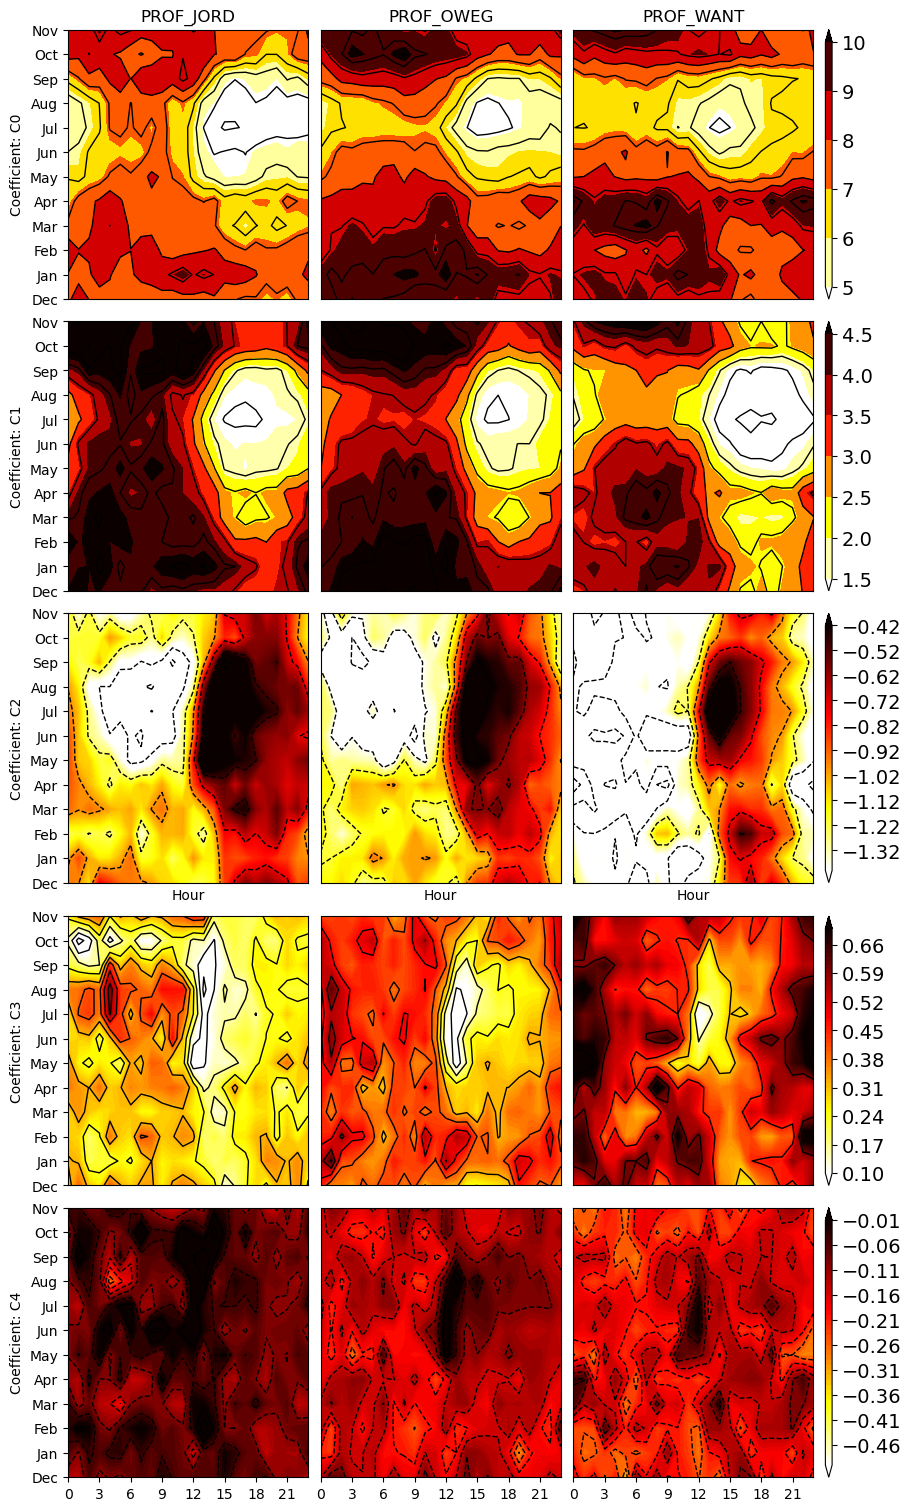

In [123]:
fig = plt.figure(figsize=(9, 15), constrained_layout=True)
levels = [np.arange(5,10.1,1),
          np.arange(1.5,4.51,0.5),
          np.arange(-1.4,-0.41,0.01),
          np.arange(0.1,0.71,0.01),
          np.arange(-0.5,0.,0.01)]
gs = fig.add_gridspec(5,3)
for coeff in range(5):

    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        row,col = coeff,i
        ax = fig.add_subplot(gs[row,col])

        ylabel = f'Coefficient: C{coeff}' if col == 0 else ''
        xlabel = 'Hour' if row == 2 else ''
        title = station_id if row == 0 else ''

        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]

        months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
        monthly_df = pd.DataFrame()
        for j,month in enumerate([12,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
            hourly_df = pd.DataFrame()
            for hour in range(0,24):
                # Extract data for the current year
                data = profiler_coeff.sel(coeff=coeff).sel(time=(profiler_coeff.time.dt.month == month) & (profiler_coeff.time.dt.hour == hour)).mean().values
                df = pd.DataFrame({hour:data}, index=pd.Index([months[j]], name='month'))
                hourly_df = pd.concat([hourly_df, df],axis=1)
            monthly_df = pd.concat([monthly_df, hourly_df],axis=0)
        
        contourf = ax.contourf(monthly_df.columns, monthly_df.index, monthly_df.values, cmap='hot_r',extend='both',levels=levels[coeff])
        ax.contour(monthly_df.columns, monthly_df.index, monthly_df.values, colors='black', linewidths=1)

        if i == 2:
            cbar = fig.colorbar(contourf, orientation='vertical', shrink=1, aspect=40)
            cbar.ax.tick_params(labelsize=14)
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # set xticks only for the bottom row
        if row == 4:
            ax.set_xticks(range(0,24,3))
            ax.set_xticklabels([str(h) for h in range(0,24,3)])
        else:
            ax.set_xticks([])
        
        # set yticks only for the left column
        if col == 0:
            ax.set_yticks(range(0,12))
            ax.set_yticklabels(months)
        else:
            ax.set_yticks([])

plt.savefig(f'{FIGDIR}/Profiler_Chebysev_monthly_diurnal_cycle_onshore_offshore_locations.pdf',bbox_inches='tight',dpi=300)

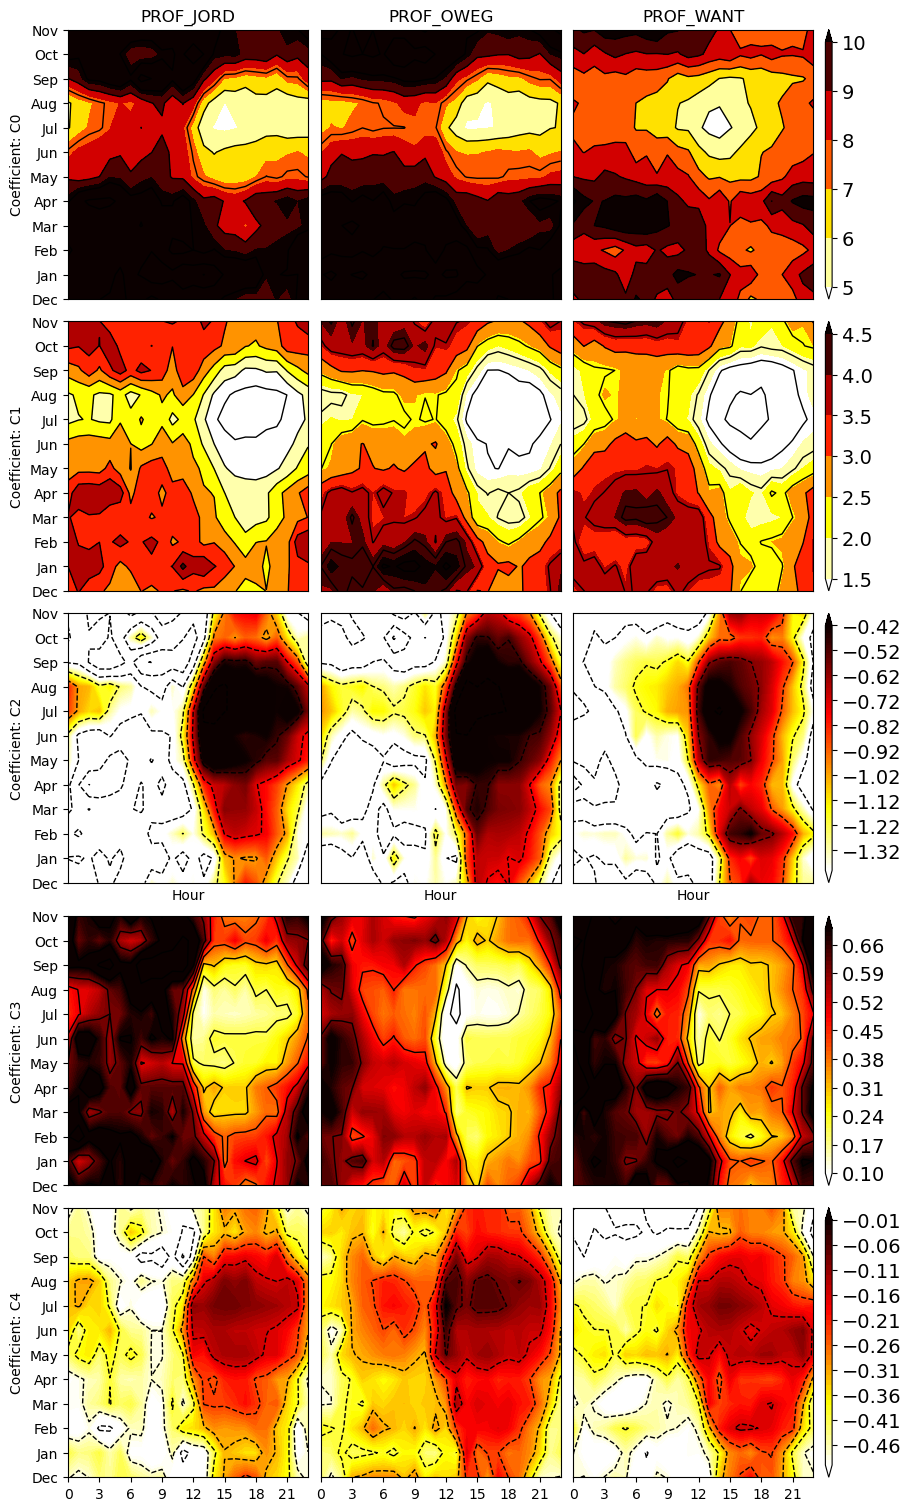

In [125]:
fig = plt.figure(figsize=(9, 15), constrained_layout=True)
levels = [np.arange(5,10.1,1),
          np.arange(1.5,4.51,0.5),
          np.arange(-1.4,-0.41,0.01),
          np.arange(0.1,0.71,0.01),
          np.arange(-0.5,0.,0.01)]
gs = fig.add_gridspec(5,3)
for coeff in range(5):

    colors = ['green','red','grey']
    for i, station_id in enumerate(['PROF_JORD','PROF_OWEG','PROF_WANT']):
        row,col = coeff,i
        ax = fig.add_subplot(gs[row,col])

        ylabel = f'Coefficient: C{coeff}' if col == 0 else ''
        xlabel = 'Hour' if row == 2 else ''
        title = station_id if row == 0 else ''

        profiler_coeff = profiler_coeff_all[station_id]
        NOW23_coeff = NOW23_coeff_all[station_id]

        months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
        monthly_df = pd.DataFrame()
        for j,month in enumerate([12,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
            hourly_df = pd.DataFrame()
            for hour in range(0,24):
                # Extract data for the current year
                data = NOW23_coeff.sel(coeff=coeff).sel(time=(NOW23_coeff.time.dt.month == month) & (NOW23_coeff.time.dt.hour == hour)).mean().values
                df = pd.DataFrame({hour:data}, index=pd.Index([months[j]], name='month'))
                hourly_df = pd.concat([hourly_df, df],axis=1)
            monthly_df = pd.concat([monthly_df, hourly_df],axis=0)
        
        contourf = ax.contourf(monthly_df.columns, monthly_df.index, monthly_df.values, cmap='hot_r',extend='both',levels=levels[coeff])
        ax.contour(monthly_df.columns, monthly_df.index, monthly_df.values, colors='black', linewidths=1)

        if i == 2:
            cbar = fig.colorbar(contourf, orientation='vertical', shrink=1, aspect=40)
            cbar.ax.tick_params(labelsize=14)
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # set xticks only for the bottom row
        if row == 4:
            ax.set_xticks(range(0,24,3))
            ax.set_xticklabels([str(h) for h in range(0,24,3)])
        else:
            ax.set_xticks([])
        
        # set yticks only for the left column
        if col == 0:
            ax.set_yticks(range(0,12))
            ax.set_yticklabels(months)
        else:
            ax.set_yticks([])

plt.savefig(f'{FIGDIR}/NOW23_Chebysev_monthly_diurnal_cycle_onshore_offshore_locations.pdf',bbox_inches='tight',dpi=300)